# TD 6 - 10th of Feb. 2023

Faisal Jayousi: jayousi@unice.fr


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm

## Forward model: the blurring operator


In SMLM type data, the acquisition consist of a blurred and noisy image of a molecule sample (the ground truth image).
Let $x\in\mathbb R^n$ be the ground truth image.
The microscope only allows us to have access to a blurred and noisy version $$y=Ax+\eta,$$
where $A:\mathbb R^n \longrightarrow \mathbb R^n$ is the forward blurring operator and $\eta\in\mathbb R^n$ is a Gaussian distributed noisy vector with $0$ mean and variance $\sigma^2$: $\eta\sim\mathcal N(0,\sigma^2)$.

Given the acquisition $y$, we aim to reconstruct the ground truth $x$. To do so, we need to understand how the microscope works and propose a forward model accordingly.

Load the ground truth image.


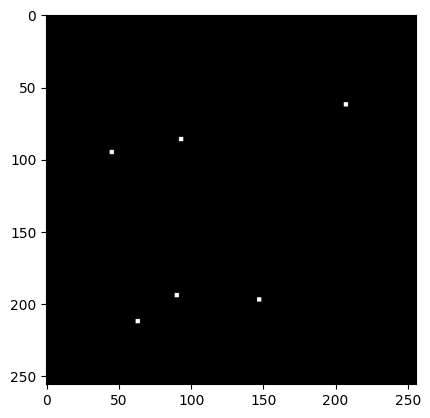

In [2]:
# load the image
gt = np.float64(plt.imread("gt.png"))
gt = gt[:, :, 1]
gt = gt * 255.0

# plot the image
plt.imshow(gt, cmap="gray")
plt.show()


We will now focus on the blurring operator. Recall that it is inconvenient (and often impossible) to construct the matrix $A$.


In [3]:
n = np.shape(gt)[0]
print("The ground truth image has dimensions " + str(n) + "*" + str(n))
print("It is a vector of lenght " + str(n * n))
print("The matrix A has dimensions " + str(n * n) + "*" + str(n * n))


The ground truth image has dimensions 256*256
It is a vector of lenght 65536
The matrix A has dimensions 65536*65536


Multiplying an image with a blurring matrix (huge) can be written as a convolution between the image itself and an appropriate kernel (that has the same size as the image), called Point Spread Function (PSF), since it describes how a point is distorted (and spread) by the microscope. To do so, the Fast Fourier Trasform is used and only the PSF has to be stored.


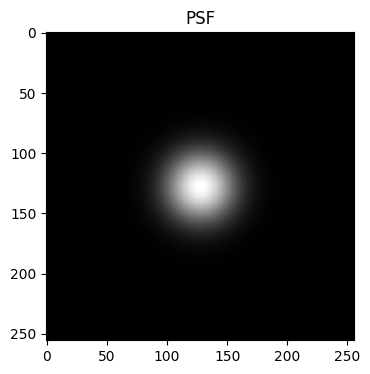

In [4]:
# convolution kernel: the point spread function PSF
s = 20
n = np.shape(gt)[0]
x = np.concatenate((np.arange(0, n / 2), np.arange(-n / 2, 0)))
[Y, X] = np.meshgrid(x, x)
h = np.exp((-(X**2) - Y**2) / (2 * s**2))
h = h / np.sum(h)

plt.figure(figsize=(4, 4))
plt.imshow(np.fft.fftshift(h), cmap="gray")
plt.title("PSF")
plt.show()


In [5]:
# define the forward operator as convolution with h
def forward_operator(x, h):
  # go to TD 4 to see how to define this
  return np.real(np.fft.ifft2(np.fft.fft2(x) * np.fft.fft2(h)))


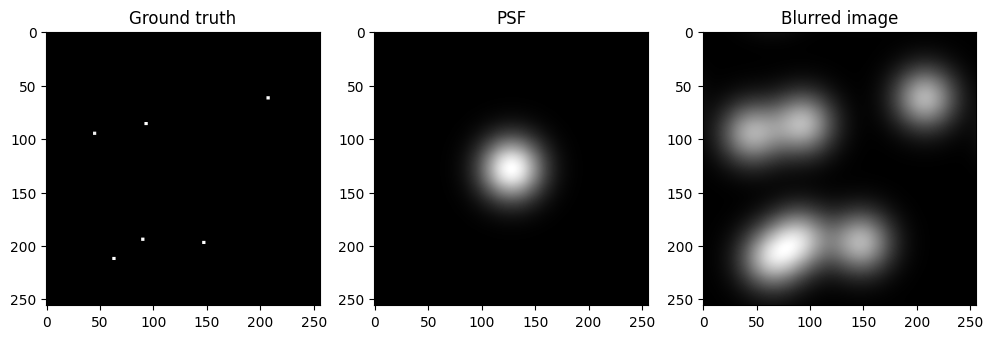

In [6]:
# compute the blurred imaage
blurred_image = forward_operator(gt, h)

# plot the ground truth, the PSF and the blurred image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gt, cmap="gray")
plt.title("Ground truth")
plt.subplot(1, 3, 2)
plt.imshow(np.fft.fftshift(h), cmap="gray")
plt.title("PSF")
plt.subplot(1, 3, 3)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred image")
plt.show()


Now we need to generate a noisy realisation of the blurred image in order to obtain a realistic acquisition.

We have two options:

1. add Gaussian noise to the blurred image


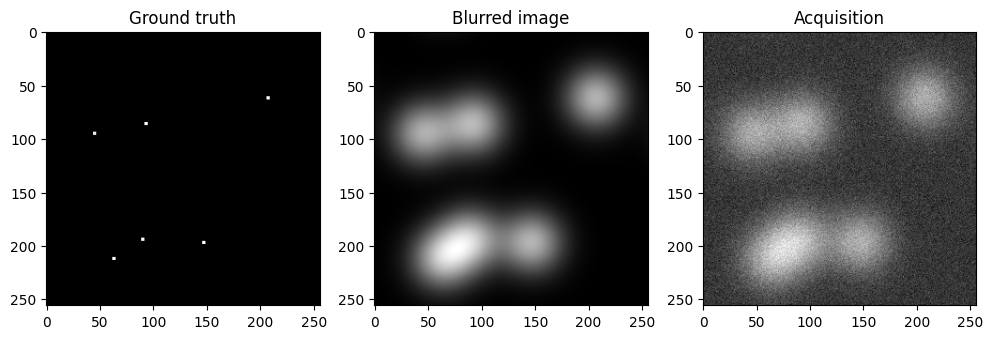

In [7]:
np.random.seed(24)
# generate gaussian noise
sigma_noise = 0.1
noise = sigma_noise * np.random.randn(n, n)  # see TD1
# add gaussian noise to the blurred image
acq = blurred_image + noise  # acquisition

# plot the ground truth, the blurred image and the final acquisition (blurred and noisy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gt, cmap="gray")
plt.title("Ground truth")
plt.subplot(1, 3, 2)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred image")
plt.subplot(1, 3, 3)
plt.imshow(acq, cmap="gray")
plt.title("Acquisition")
plt.show()


2. add image-dependent Poisson noise to the blurred image. It is more realistic but more difficult to consider from a mathematical point of view. In the following we will use Gaussian noise for simplicity.


In [8]:
# # poisson noise
# acq_p = np.random.poisson  # see TD1

# # plot the ground truth, the blurred image and the final acquisition (blurred and noisy)
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 1)
# plt.imshow(gt, cmap="gray")
# plt.title("Ground truth")
# plt.subplot(1, 3, 2)
# plt.imshow(blurred_image, cmap="gray")
# plt.title("Blurred image")
# plt.subplot(1, 3, 3)
# plt.imshow(acq_p, cmap="gray")
# plt.title("Acquisition")
# plt.show()


## Implementation of the Forward-Backward algorithm (ISTA)


Let $y\in\mathbb R^n$ be a noisy acquisition and $A:\mathbb R^n \longrightarrow \mathbb R^n$ the blurring operator. To solve the inverse problem i.e. to find $x\in\mathbb R^n$ such that $$y=Ax+\eta$$, we use a variational approach and solve
$$ \operatorname{argmin}_{x\in\mathbb R^n} \frac{1}{2}\|Ax-y\|\_2^2+\lambda \|x\|\_1+\texttt{i}_{\ge 0}(x) $$
with the Forward-Backward algorithm.

The first step of FB algorithm is the forward step: a gradient descent step for the smooth function $f$.

Implement a function that computes the gradient of $f$, $\nabla f(x)= A^t (Ax-y)$.


In [9]:
# define the gradient of the fidelity term in terms of convolutions
def gradient(x, h, y):
  aus = forward_operator(x, h) - y
  return np.real(np.fft.ifft2(np.conj(np.fft.fft2(h)) * np.fft.fft2(aus)))


Compute now the Lipschitz constant of $\nabla f$, recalling that $L=\|A\|^2$. This will be needed for choosing a suitable stepsize.


In [10]:
# compute the Lipschitz constant Lips
hF = np.real(np.fft.fft2(np.fft.fftshift(h)))
Lips = np.max(hF**2)


Go to TD 5 and copy here the code of the soft thresholding function. You need it to define the backward step in terms of the penzlty $g(x)=\|x\|_1$.


In [11]:
# prox of \ell_1 norm: soft thresholding function
def soft_thresholding(x, gamma):
  return np.sign(x) * np.maximum(np.abs(x) - gamma, 0)


Implement a function that computes the fidelity term $f(x)=\frac{1}{2}\|Ax-y\|_2^2$ and the cost function $F(x)=\frac{1}{2}\|Ax-y\|_2^2+\lambda \|x\|_1$ at each point.


In [12]:
# fidelity
def fidelity(x, h, y):
  return 0.5 * np.linalg.norm(forward_operator(x, h) - y) ** 2


# cost function
def cost_function(x, h, y, lmbda):
  return fidelity(x, h, y) + lmbda * np.linalg.norm(x, 1)


You have now the elements to define the function for the FB algorithm.


In [19]:
# input parameters
# x0 is the initialisation
# tau is the stepsize
# lambda is the regularisation parameter
# y is the acquisition, h is the psf ---> needed to compute the gradient of f at each iteration
# epsilon is the tolerance parameter, maxiter is the maximum numer of iterations ---> needed for the stopping criterion


def FB(x0, tau, lmbda, y, h, epsilon, maxiter):
  """
  Forward-backward algorithm.
  """
  xk = x0
  cost = np.zeros(maxiter)
  norms = np.zeros(maxiter)

  for i in np.arange(maxiter):

    if i % 100 == 0:
      print(f"Iteration {i}/{maxiter}")

    # forward step: gradient descent of f
    xkk = xk - tau * gradient(x=xk, h=h, y=y)

    # backward step
    xk = soft_thresholding(x=xkk, gamma=tau * lmbda)

    # positivity constraints
    xkk = np.maximum(0, xk)

    # compute the cost function
    cost[i] = cost_function(x=xk, h=h, y=y, lmbda=lmbda)

    # compute the relative change between the iterations
    norms[i] = np.linalg.norm(xkk - xk, "fro")

    # update your iteration
    xk = xkk

    # if the cost is decreasing a lot I stop before reaching maxiter
    if np.abs(cost[i] - cost[i - 1]) / cost[i] < epsilon:
      print(f"Early stopping at iteration {i}")
      break

  return xk, cost, norms


Check that your algorithm is working by computing the reconstruction for the following set of input parameters.


Iteration 0/1000
Iteration 100/1000
Iteration 200/1000
Iteration 300/1000
Iteration 400/1000
Iteration 500/1000
Iteration 600/1000
Iteration 700/1000
Iteration 800/1000
Iteration 900/1000


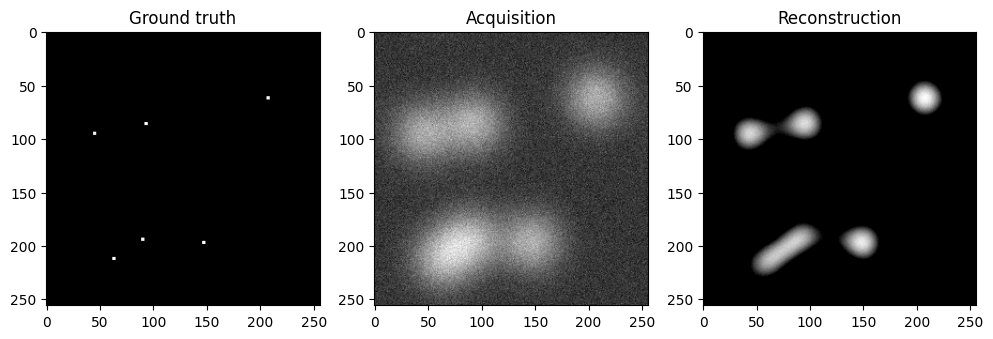

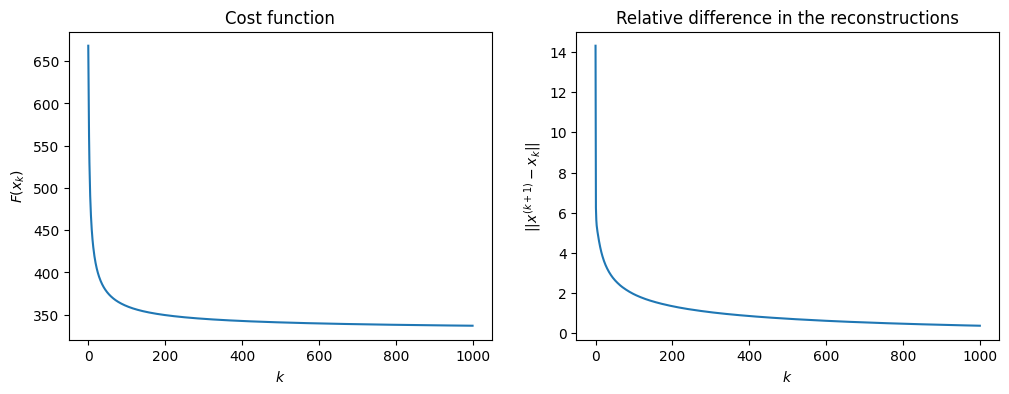

In [31]:
dim = (n, n)
x0 = np.zeros(dim)
# x0 = blurred_image
x0 = acq
tau = 0.8
lmbda = 0.006
maxiter = 1000
epsilon = 0.00001

# compute the reconstruction
rec, cost, norms = FB(
  x0=x0, tau=tau, lmbda=lmbda, y=acq, h=h, epsilon=epsilon, maxiter=maxiter
)

# plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gt, cmap="gray")
plt.title("Ground truth")
plt.subplot(1, 3, 2)
plt.imshow(acq, cmap="gray")
plt.title("Acquisition")
plt.subplot(1, 3, 3)
plt.imshow(rec, cmap="gray")
plt.title("Reconstruction")
plt.show()

# plot how the cost function decreases and how the iterates converge
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cost)
plt.xlabel("$k$")
plt.ylabel("$F(x_k)$")
plt.title("Cost function")
plt.subplot(1, 2, 2)
plt.plot(norms)
plt.xlabel("$k$")
plt.ylabel("$||x^{(k+1)}-x_{k}||$")
plt.title("Relative difference in the reconstructions")
plt.show()


## Questions: regularisation parameter


1. Try different values of the regularisation parameter and see what happens. Can you explain the behaviour of the reconstructions with respect to $\lambda$? Does the choice of $\lambda$ affect the reconstruction?


In [ ]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.01
maxiter = 1000
epsilon = 0

# choose some values for lmbda
lmbda = None

# compute the reconstruction


2. For example try $\lambda=0$. What happens? Which algorithm are you actually using in this very particular case? (Look both at the reconstructed image and at the equation defining the model with $\lambda=0$)


## Questions: step-size

To answer the following questions set $\lambda=0.3$, $maxiter = 1000$, $\epsilon = 0$ and $x_0=0$.

3. Try a very small stepsize and have a look at how the cost function is decreasing.


4. Then try $\tau=\frac{1}{Lips}$. What do you observe?


5. Then try $\tau>>\frac{1}{Lips}$. What do you observe?

(Hint: plot the cost functions in the three cases)


In [ ]:
tau = 5


## Questions: Fast Iterative Soft Thresholding Algorithm


6. Starting from the function for the FB algorithm defined above, write a code for the Fast Iterative Soft Thresholding Algorithm (FISTA).


In [42]:
def FISTA(x0, tau, lmbda, y, h, epsilon, maxiter):
  """
  FISTA algorithm.
  """
  


Check that your algorithm is working by computing the reconstruction for the following set of input parameters.


Iteration 0/1000
Iteration 100/1000
Iteration 200/1000
Iteration 300/1000
Iteration 400/1000
Iteration 500/1000
Iteration 600/1000
Iteration 700/1000
Iteration 800/1000
Iteration 900/1000


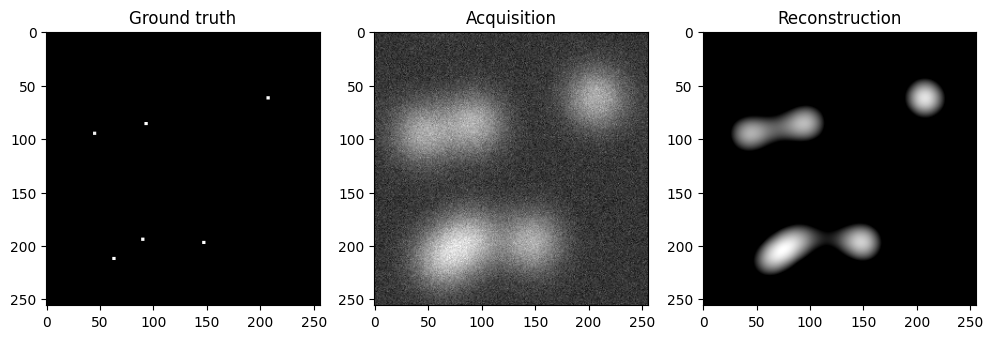

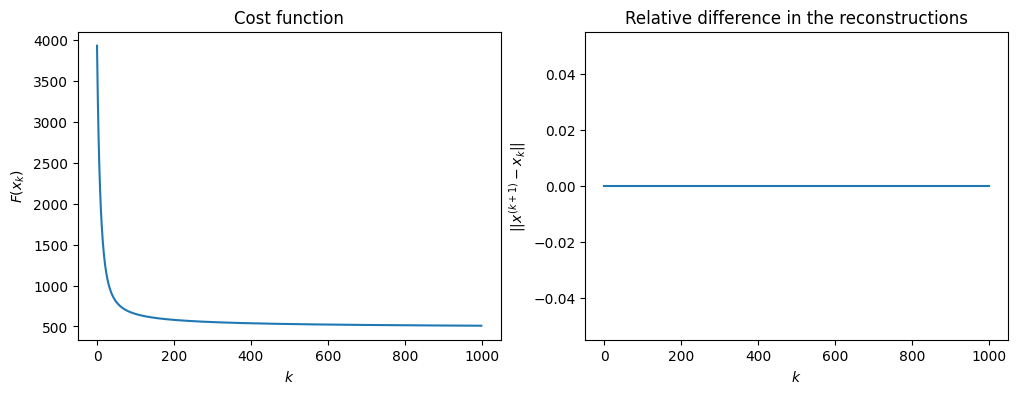

In [43]:
dim = (n, n)
x0 = np.zeros(dim)
tau = 0.11
lmbda = 0.1
maxiter = 1000
epsilon = 0.001

# compute the reconstruction
rec, cost, norms = FISTA(x0, tau, lmbda, acq, h, 0, maxiter)

# plot the ground truth, the final acquisition (blurred and noisy) and the reconstruction
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gt, cmap="gray")
plt.title("Ground truth")
plt.subplot(1, 3, 2)
plt.imshow(acq, cmap="gray")
plt.title("Acquisition")
plt.subplot(1, 3, 3)
plt.imshow(rec, cmap="gray")
plt.title("Reconstruction")
plt.show()

# plot how the cost function decreases and how the iterates converge
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cost)
plt.xlabel("$k$")
plt.ylabel("$F(x_k)$")
plt.title("Cost function")
plt.subplot(1, 2, 2)
plt.plot(norms)
plt.xlabel("$k$")
plt.ylabel("$||x^{(k+1)}-x_{k}||$")
plt.title("Relative difference in the reconstructions")
plt.show()


7. Compared to the reconstruction with the ISTA or FB algorithm, how does the cost function decrease? Set $\lambda=0.3$, $\tau=\frac{1}{Lips}$, $maxiter = 1000$, $\epsilon = 0$ and $x_0=0$ in both cases.
